# **End to End Fine Tuning Transfer Learning**

In the previous notebook I covered a comprehensive exploration of transfer learning using pre-trained models from TensorFlow Hub. It focuses on efficiency and experimentation with a reduced dataset (10% of the original). The key highlights include:

1. **Transfer Learning with TensorFlow:** An introduction to the concept of transfer learning and how to apply it using TensorFlow.

2. **Leveraging a Reduced Dataset:** Demonstrating the advantages of working with a smaller dataset for faster experimentation.

3. **Building a Transfer Learning Feature Extraction Model:** Creating feature extraction models with TensorFlow Hub, with a focus on two pre-trained models: EfficientB0 and ResNet50.

4. **Tracking Progress with TensorBoard:** Introducing TensorBoard as a tool to monitor and visualize modeling experiments. The primary goal is to compare conventional CNNs with pre-trained models, with EfficientB0 standing out for its superior accuracy and efficiency.


## What I'm going to cover
1. **Introduce fine-tuning transfer learning** with TensorFlow, a technique that leverages pre-trained models for improved performance.
2. **Introduce the Keras Functional API** to build intricate and customized models.
3. Speed up your experimentation by working with a reduced dataset, such as utilizing only **10% of the training samples**.
4. Enhance dataset diversity through the application of **data augmentation**, a method that enriches the training set without the need for additional data samples.
5. Conduct a series of comprehensive experiments using the **Food Vision dataset**, allowing for in-depth analysis and model refinement.
6. Implement the **Model Checkpoint callback** to save intermediate training results, providing a safety net for your model's progress tracking and potential recovery in case of interruptions.

In [6]:
# Check for GPU
!nvidia-smi

Mon Oct 16 08:49:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Creating helper functions
I use the script in my Github repo

In [7]:



!wget https://raw.githubusercontent.com/joe-seth/Food-101-Computer-Vision-Project/main/extras/script_functions.py

--2023-10-16 08:49:29--  https://raw.githubusercontent.com/joe-seth/Food-101-Computer-Vision-Project/main/extras/script_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10267 (10K) [text/plain]
Saving to: ‘script_functions.py.1’

script_functions.py 100%[===================>]  10.03K  --.-KB/s    in 0s      

2023-10-16 08:49:29 (81.3 MB/s) - ‘script_functions.py.1’ saved [10267/10267]



In [8]:
# Import helper functions from script_functions
from script_functions import create_tensorboard_callback, plot_loss_curve, unzip_data, walk_through_dir

In [9]:
# Get 10% of the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-10-16 08:49:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   248MB/s    in 0.6s    

2023-10-16 08:49:30 (248 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [10]:
# Check how many images and subdirectories are in the dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [11]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                        image_size=IMG_SIZE,
                                                                        label_mode='categorical',
                                                                        batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [13]:

train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [14]:

# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [15]:


# see the batches in train_data_10_percent
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.92127548e+02 1.83556122e+02 1.59602036e+02]
   [1.87545929e+02 1.68520401e+02 1.44591827e+02]
   [1.47765305e+02 1.17897957e+02 9.38367310e+01]
   ...
   [1.97862259e+02 2.23862259e+02 2.48862259e+02]
   [1.98000000e+02 2.24000000e+02 2.49000000e+02]
   [1.97872437e+02 2.23872437e+02 2.48872437e+02]]

  [[1.99311218e+02 1.84311218e+02 1.58005112e+02]
   [1.76693878e+02 1.51204071e+02 1.24275497e+02]
   [1.10505096e+02 7.51785736e+01 4.74489784e+01]
   ...
   [1.96801041e+02 2.22801041e+02 2.47801041e+02]
   [1.98000000e+02 2.24000000e+02 2.49000000e+02]
   [1.98000000e+02 2.24000000e+02 2.49000000e+02]]

  [[1.79168365e+02 1.54102036e+02 1.22255096e+02]
   [1.50387756e+02 1.17015297e+02 8.54438629e+01]
   [1.36301010e+02 9.42295914e+01 6.16326523e+01]
   ...
   [1.97000000e+02 2.23000000e+02 2.48000000e+02]
   [1.96984695e+02 2.22984695e+02 2.47984695e+02]
   [1.95785721e+02 2.21785721e+02 2.46785721e+02]]

  ...

  [[1.72790802e+02 1.89362274e+02 2.09576538e+02]
   [1

In [16]:
# Build a sample model using tf.keras.application
model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_tensor= None,
    input_shape=(224,224,3),
    pooling=max,
    classes=10,
    classifier_activation='softmax'
)

# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit the model
history = model.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data = test_data,
                    validation_steps = len(test_data)
                    )

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/5


ValueError: ignored

If using ResNet50V2 there is need to normalize the inputs

In [24]:
# 1. Create a base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pretrained models aren't updated)
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# 4. optional(Normalize the inputs for models like ResNet50V2. No normalization needed for Efficientnet50)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# 5. Pass the input to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the outpt activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("transfer learning", "10_percent_feature_extraction")])



Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer learning/10_percent_feature_extraction/20231016-085243
Epoch 1/5
24/24 [==============================] - 16s 361ms/step - loss: 1.8605 - accuracy: 0.4240 - val_loss: 1.2967 - val_accuracy: 0.7320
Epoch 2/5
24/24 [==============================] - 8s 311ms/step - loss: 1.0882 - accuracy: 0.7680 - val_loss: 0.8728 - val_accuracy: 0.8144
Epoch 3/5
24/24 [==============================] - 8s 336ms/step - loss: 0.7819 - accuracy: 0.8187 - val_loss: 0.7044 - val_accuracy: 0.8352
Epoch 4/5
24/24 [==============================] - 12s 514ms/step - loss: 0.6253 - accuracy: 0.8507 - val_loss: 0.6157 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 7s 299ms/step - loss: 0.5435 - accuracy: 0.8787 - val_loss: 0.5611 - val_accuracy: 0.8572


In [25]:
# Evaluate
model_0.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.5611 - accuracy: 0.8572


[0.5610828399658203, 0.857200026512146]

In [26]:
# Check the layers in the base model
for i_number, i in enumerate(base_model.layers):
  print(i_number, i.name)

0 input_4
1 rescaling_4
2 normalization_2
3 rescaling_5
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [27]:
# Get the summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, None, None, 3)        0         ['input_4[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, None, None, 3)        7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, None, None, 3)        0         ['normalization_2

In [28]:
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
________________

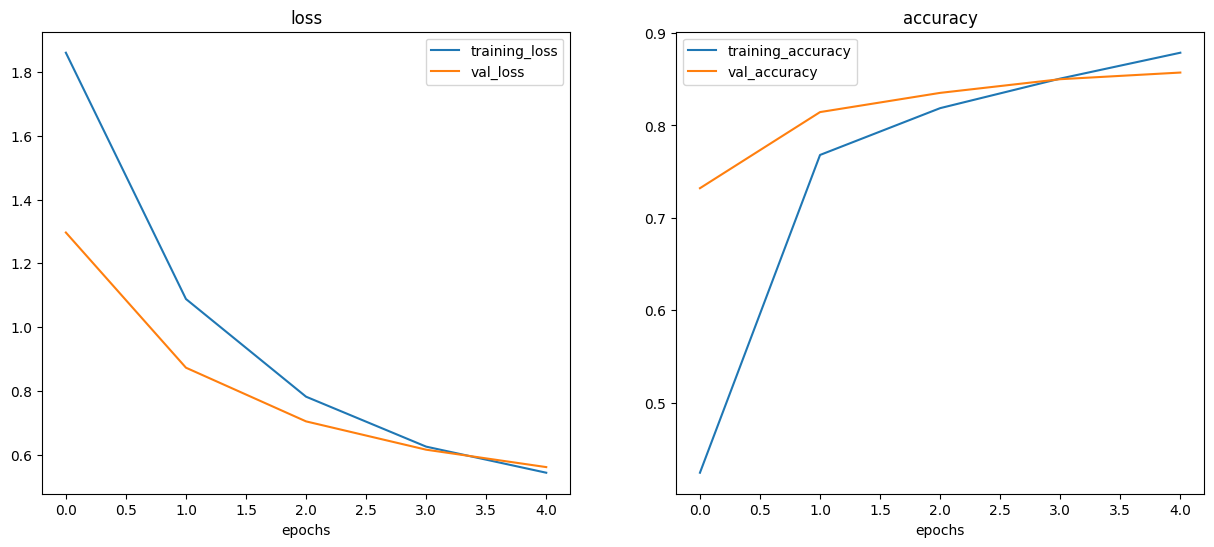

In [29]:
# check the loss curver
plot_loss_curve(history=history_0)






## Feature Vectorization















## Getting a feature vector from a trained model
Demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape(None,7,7,1280)

But when it passes throught the GlobalAveragePooling2D, it turns into(None, 1280)

Try using as similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [30]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a ranfom tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [31]:
input_tensor.ndim

4

In [32]:
# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]



In [33]:
# GEt the shape
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooling 2D tensor: {global_average_pooled_tensor}")

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooling 2D tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]








A pretrained model outputs a feature vector

**Note:** The GlobalAveragePooling2d condenses the input_tensor so that it can be fed to output dense layer

In [34]:
# Replicate the GlobalAveragePooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>


## Running a series of transfer learning experiments
So far I've seen the incredible results of transfer learning on just 10% of the data, how will it perform on 1% of the training data.

Perform a bunch of experiments to find out....
1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - Use feature extraction transfer learning with transfer learing iwth 10% of the training data with dat augmentation
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine tuning transfer on 100% of the data

In [35]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2023-10-16 08:55:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   242MB/s    in 0.5s    

2023-10-16 08:55:53 (242 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [36]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

In [37]:
# How many images are there:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

## Getting and preprocessing data for model_1

In [38]:

# setup the data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default=32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation right into the model

Use the layers inside to add data augmention into the model

* `tf.keras.layers.experimental.preprocessing()`

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

## Visualize the augmentated data

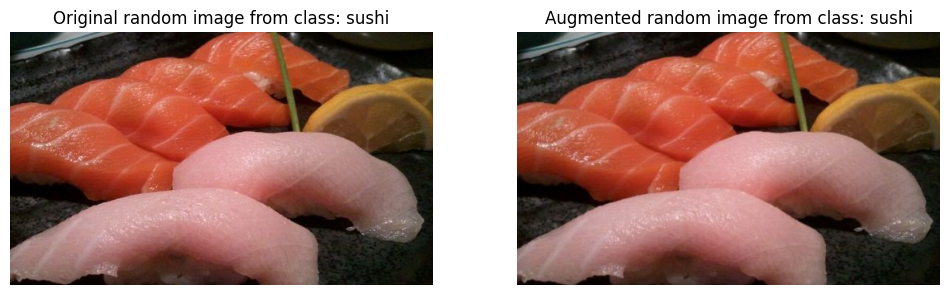

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import tensorflow as tf

# Define the path to your dataset directory
dataset_dir = "10_food_classes_1_percent/train/"

# Choose a random class
target_class = random.choice(os.listdir(dataset_dir))

# Create the target directory
target_dir = os.path.join(dataset_dir, target_class)

# Choose a random image from the target directory
random_image = random.choice(os.listdir(target_dir))

# Create the chosen random image path
random_image_path = os.path.join(target_dir, random_image)

# Read in the chosen target image
img = mpimg.imread(random_image_path)

# Create a figure with subplots
plt.figure(figsize=(12, 6))

# Plot the original random image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Augment the image
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),])
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # Data augmentation model requires shape (None, height, width, 3)
plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(augmented_img) / 255.0) # Requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

plt.show()


## Model 1: Feature extraction transfer learning on 1% of the data augmentation

In [91]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give the base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on the output
outputs = layers.Dense(10, activation='Softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps = len(test_data),
                                # Track the model training logs
                                callbacks = [create_tensorboard_callback(dir_name='transfer_learning',
                                                                         experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231016-095724
Epoch 1/5
3/3 [==============================] - 15s 4s/step - loss: 2.4207 - accuracy: 0.1000 - val_loss: 2.2721 - val_accuracy: 0.1664
Epoch 2/5
3/3 [==============================] - 9s 4s/step - loss: 2.1755 - accuracy: 0.2286 - val_loss: 2.1456 - val_accuracy: 0.2460
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9322 - accuracy: 0.3714 - val_loss: 2.0349 - val_accuracy: 0.3048
Epoch 4/5
3/3 [==============================] - 6s 3s/step - loss: 1.8113 - accuracy: 0.4857 - val_loss: 1.9323 - val_accuracy: 0.3580
Epoch 5/5
3/3 [==============================] - 8s 4s/step - loss: 1.6476 - accuracy: 0.5286 - val_loss: 1.8361 - val_accuracy: 0.4036


**Impressive**

The val_accuracy at 48% is quite close to the Food101 paper where they achieved a 50% accuracy

In [92]:
# Check the model summary
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

In [93]:
# Evalauate on the full test dataset
results = model_1.evaluate(test_data)
results

79/79 [==============================] - 8s 87ms/step - loss: 1.8361 - accuracy: 0.4036


[1.8360592126846313, 0.4036000072956085]

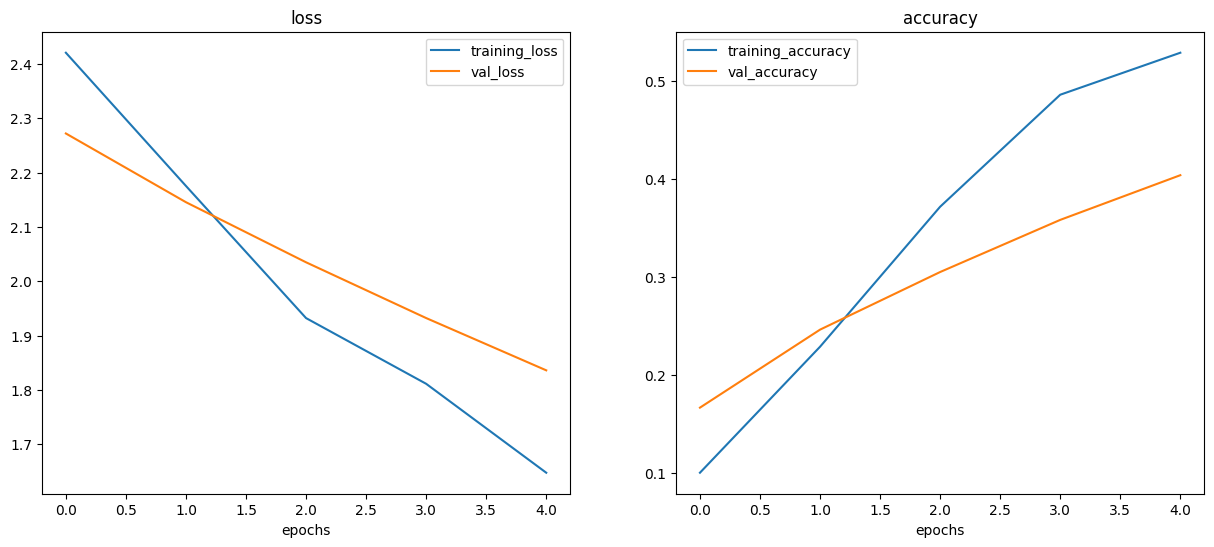

In [94]:
# visualize the loss curves
plot_loss_curve(history=history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation

In [95]:
# Get 10% of data
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = '10_food_classes_10_percent/test'

In [96]:
# set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [97]:
# How many images are the directories?
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [98]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
], name='data_augmentation')

# Setup the input shape
input_shape = (224,224, 3)

# Create  a frozen base model(also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the  inputs and outputs (including layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs) # augment the training data
x = base_model(x, training=False) # pass the aug images to the base model but keep the base model in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Setup the model
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [99]:
# Creating a model checkpoint callback
checkpoint_path ='ten_percent_model_checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq='epoch',
                                                       verbose=1)

In [100]:
# Fit the model passing in the ModelCheckpoint callback
initial_epochs = 5
history_model_2 = model_2.fit(train_data_10_percent,
                              epochs=initial_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=len(test_data),
                              callbacks= [create_tensorboard_callback(dir_name='transfer_learning',
                                                                      experiment_name='10_percent_data_aug'),
                                                                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20231016-095826
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0161 - accuracy: 0.3173
Epoch 1: saving model to ten_percent_model_checkpoint.ckpt
24/24 [==============================] - 25s 668ms/step - loss: 2.0161 - accuracy: 0.3173 - val_loss: 1.4869 - val_accuracy: 0.6768
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3419 - accuracy: 0.6720
Epoch 2: saving model to ten_percent_model_checkpoint.ckpt
24/24 [==============================] - 16s 672ms/step - loss: 1.3419 - accuracy: 0.6720 - val_loss: 1.0119 - val_accuracy: 0.8016
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0326 - accuracy: 0.7413
Epoch 3: saving model to ten_percent_model_checkpoint.ckpt
24/24 [==============================] - 16s 662ms/step - loss: 1.0326 - accuracy: 0.7413 - val_loss: 0.8027 - val_accuracy: 0.8348
Epoch 4/5
24/24 [==============================] - ETA: 0s - 

In [101]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.5611 - accuracy: 0.8572


[0.5610828399658203, 0.857200026512146]

In [102]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 69ms/step - loss: 0.6254 - accuracy: 0.8452


[0.6254155039787292, 0.8452000021934509]

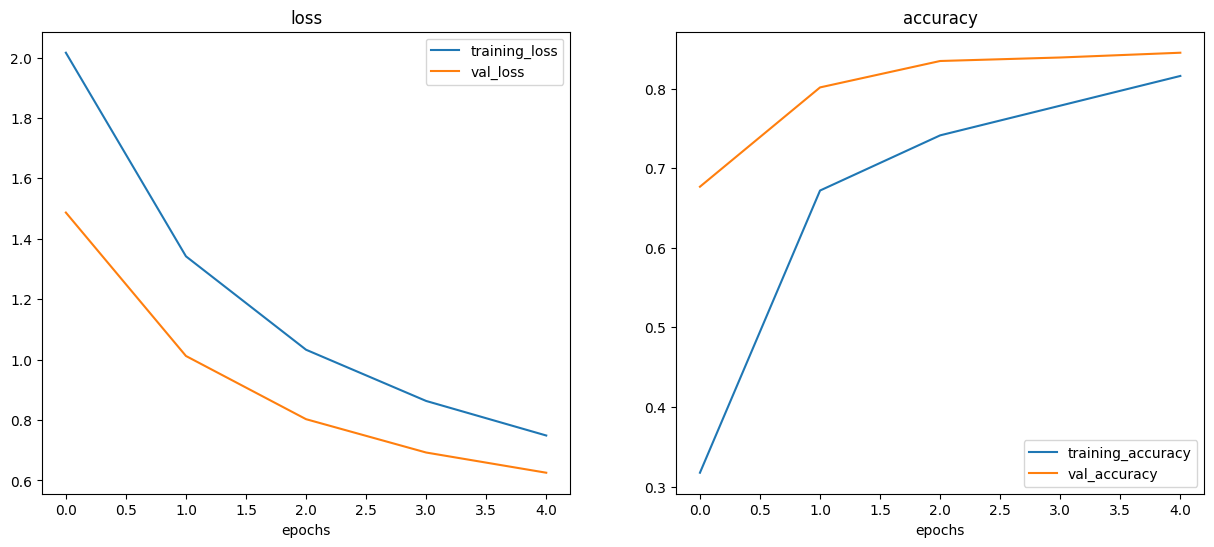

In [103]:
# Plot the loss curve for model_2
plot_loss_curve(history=history_model_2)

### Loading in the checkpoint weights
To return the model to a specific checkpoint

In [104]:
# Load in saved model weights in model_2
model_2.load_weights(checkpoint_path)

In [105]:
# Evaluate model_2 with loaded weitghs
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.6254 - accuracy: 0.8452


In [106]:
loaded_weights_model_results == results_10_percent_data_aug

True

In [107]:
loaded_weights_model_results, results_10_percent_data_aug

([0.6254155039787292, 0.8452000021934509],
 [0.6254155039787292, 0.8452000021934509])

In [108]:
# Check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [109]:
# Check the difference
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[0. 0.]


# Model 3: Fine Tuning an existing model on 10% of the data
> **Note:** Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

In [110]:
# Layers in loaded model
model_2.layers

In [111]:
# Are these layers trainable?
for i in model_2.layers:
  print(i, i.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7c927ec1b460> True
<keras.src.engine.sequential.Sequential object at 0x7c927eb44af0> True
<keras.src.engine.functional.Functional object at 0x7c91c9cdb970> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7c91c9c28df0> True
<keras.src.layers.core.dense.Dense object at 0x7c91d4ba3820> True


In [112]:
# What layers are in the model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_8 False
1 rescaling_12 False
2 normalization_6 False
3 rescaling_13 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fa

In [113]:
# How many trainable variables
print(len(model_2.layers[2].trainable_variables))


0


In [114]:
# Set the last 10 layers of the base_model.traibale=True
base_model.trainable=True

# Freeze al layers except for the last 10
for layer in base_model.layers[:-10]:
  layers.trainable = True

# After making a change, we have to recompile the model every other time
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # typically lower learning rate by 10X
                metrics=['accuracy'])

In [115]:
# Check the trainable layers
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_8 True
1 rescaling_12 True
2 normalization_6 True
3 rescaling_13 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block

In [116]:
print(len(model_2.trainable_variables))

213


In [117]:
model_2.trainable_variables

[<tf.Variable 'stem_conv/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.27994761e-02,
            2.23197415e-02, -1.42137900e-01],
          [ 1.28902495e-02,  1.56575632e+00, -1.80467033e+00,
            7.77730107e-01,  6.52952865e-02,  2.08790317e-01,
           -8.81190374e-02, -3.78276139e-01,  5.80090940e-01,
           -3.44047934e-01,  6.91463649e-02, -8.79267603e-02,
         

In [118]:

# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine = model_2.fit(train_data_10_percent,
                           epochs=fine_tune_epochs,
                           validation_data=test_data,
                           validation_steps= int(0.25 * len(test_data)),
                           initial_epoch = history_model_2.epoch[-1],# start training from previous last epoch
                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                  experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20231016-100042
Epoch 5/10
24/24 [==============================] - 62s 755ms/step - loss: 0.5997 - accuracy: 0.8200 - val_loss: 0.4629 - val_accuracy: 0.8734
Epoch 6/10
24/24 [==============================] - 12s 506ms/step - loss: 0.3671 - accuracy: 0.8920 - val_loss: 0.4525 - val_accuracy: 0.8602
Epoch 7/10
24/24 [==============================] - 15s 622ms/step - loss: 0.2510 - accuracy: 0.9307 - val_loss: 0.4296 - val_accuracy: 0.8553
Epoch 8/10
24/24 [==============================] - 17s 674ms/step - loss: 0.1810 - accuracy: 0.9440 - val_loss: 0.4159 - val_accuracy: 0.8717
Epoch 9/10
24/24 [==============================] - 16s 644ms/step - loss: 0.1293 - accuracy: 0.9653 - val_loss: 0.3878 - val_accuracy: 0.8799
Epoch 10/10
24/24 [==============================] - 21s 876ms/step - loss: 0.0955 - accuracy: 0.9760 - val_loss: 0.4666 - val_accuracy: 0.8602


In [119]:
# Evaluate the fine tuned model
results_fine_tuned_model = model_2.evaluate(test_data)

79/79 [==============================] - 6s 67ms/step - loss: 0.4352 - accuracy: 0.8636


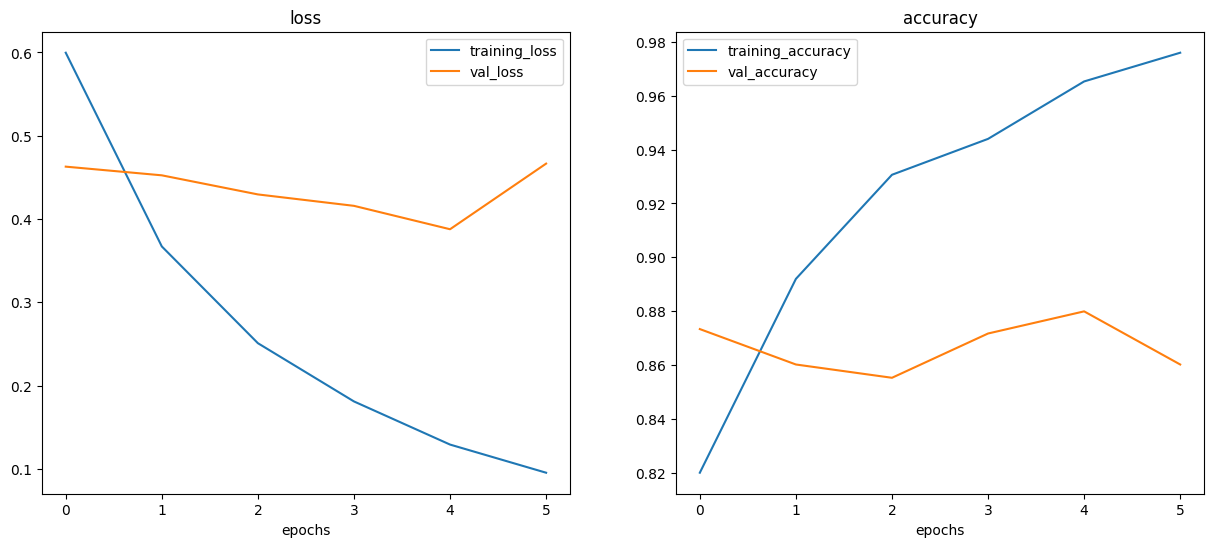

In [120]:
plot_loss_curve(history=history_fine)

The `plot_loss_curve` function works great with models that have only been fit once. Now I want function that compares the series of running `fit()` with another(eg. before and after tuning)

In [121]:
import plotly.graph_objs as go
import plotly.subplots as sp

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compare the accuracy and loss using two separate subplots within the same figure.
    """
    # Get the original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']

    # Combine the original history
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

    # Create a figure with subplots
    fig = sp.make_subplots(
        rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1,
        subplot_titles=("Accuracy", "Loss"),
        row_heights=[0.5, 0.5]  # Equal height for both subplots
    )

    # Add training accuracy and validation accuracy to the first subplot
    fig.add_trace(go.Scatter(x=list(range(1, len(total_acc) + 1)), y=total_acc, mode='lines+markers',
                             name='Training Accuracy'), row=1, col=1)
    fig.add_trace(go.Scatter(x=list(range(1, len(total_val_acc) + 1)), y=total_val_acc, mode='lines+markers',
                             name='Validation Accuracy'), row=1, col=1)

    # Add training loss and validation loss to the second subplot
    fig.add_trace(go.Scatter(x=list(range(1, len(total_loss) + 1)), y=total_loss, mode='lines+markers',
                             name='Training Loss'), row=2, col=1)
    fig.add_trace(go.Scatter(x=list(range(1, len(total_val_loss) + 1)), y=total_val_loss, mode='lines+markers',
                             name='Validation Loss'), row=2, col=1)

    # Add a vertical line to indicate the start of fine-tuning
    fig.add_shape(type="line", x0=initial_epochs, x1=initial_epochs, y0=0, y1=1, line=dict(color="aqua", width=2),
                  xref="x", yref="paper", opacity=0.7)

    # Update layout
    fig.update_layout(
        title="Training and Validation Metrics",
        xaxis_title="Epoch",
        legend=dict(x=0.9, y=0.5),
        annotations=[dict(
            x=initial_epochs,
            y=1.05,
            xref="x",
            yref="paper",
            text="Start Fine Tuning",
            showarrow=True,
            arrowhead=2,
            arrowcolor="yellow",
            arrowsize=1,
        )]
    )

    # Display y-axis labels
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    fig.update_yaxes(title_text="Loss", row=2, col=1)

    # Increase the overall figure height
    fig.update_layout(height=800)  # Adjust the height as needed

    # Show the interactive plot
    fig.show()

# Example usage:
# compare_accuracy_and_loss(original_history, new_history)


In [122]:
compare_historys(history_model_2, history_fine, initial_epochs=5)

## Fine Tuning Model_4 on all the features

---




In [123]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2023-10-16 10:03:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  68.8MB/s    in 7.1s    

2023-10-16 10:03:39 (69.9 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [124]:
# setup train dir and test dir
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir ="10_food_classes_all_data/test/"

In [125]:
# How many images are in the directories
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.

In [126]:
# Set data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                  label_mode='categorical',
                                                                                  image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Same dataset as for the previous experiments

In [127]:
# Evaluate model_2 (fine-tund on 10 percent of data)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.4352 - accuracy: 0.8636


[0.4351731836795807, 0.8636000156402588]

To fine tune model_4, revert model_2 back to its feature extraction weights

In [128]:
# Load weights from the checkpoint, fine-tune from the same stage the 10 percent data was fine tuned from
model_2.load_weights(checkpoint_path)

ValueError: ignored

In [129]:
# Check to see if the model has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6254155039787292, 0.8452000021934509]

Alright, the previous steps might seem quite confusing, but all I've done is :
1. Trained a feature extraction transfer learning model for 5 epochs on 10 percent of the data with data augmentation(model_2) and saved the model's weights using `ModelCheckpoint` callback
2. Fine-tuned the same model on the same 10% of the data for a furhter 5 epochs with the top 10 layers of the base model unfrozen
3. Save the results and training logs each time
4. Releoaded the model from step 1 as step 2 except this time using all the data(model_4)

In [130]:
# Check which layers are tunable
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [131]:
# Drill into the base model and see which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number,layer.name, layer.trainable)

0 input_8 True
1 rescaling_12 True
2 normalization_6 True
3 rescaling_13 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block

In [132]:
# compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [133]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           initial_epoch=history_model_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='full data fine tuning')])

Saving TensorBoard log files to: transfer_learning/full data fine tuning/20231016-100958
Epoch 5/10
235/235 [==============================] - 187s 579ms/step - loss: 0.5599 - accuracy: 0.8209 - val_loss: 0.3234 - val_accuracy: 0.8960
Epoch 6/10
235/235 [==============================] - 122s 518ms/step - loss: 0.3754 - accuracy: 0.8797 - val_loss: 0.2405 - val_accuracy: 0.9268
Epoch 7/10
235/235 [==============================] - 116s 494ms/step - loss: 0.2841 - accuracy: 0.9101 - val_loss: 0.2795 - val_accuracy: 0.9100
Epoch 8/10
235/235 [==============================] - 115s 483ms/step - loss: 0.2171 - accuracy: 0.9281 - val_loss: 0.2766 - val_accuracy: 0.9124
Epoch 9/10
235/235 [==============================] - 113s 482ms/step - loss: 0.1540 - accuracy: 0.9497 - val_loss: 0.3402 - val_accuracy: 0.8984
Epoch 10/10
235/235 [==============================] - 106s 448ms/step - loss: 0.1367 - accuracy: 0.9561 - val_loss: 0.2490 - val_accuracy: 0.9292


The model did improve its accuracy  and also its time increases by 5x per epoch

In [134]:
# Evaluate on all the data
results_full_data= model_2.evaluate(test_data)
results_full_data

79/79 [==============================] - 6s 75ms/step - loss: 0.2490 - accuracy: 0.9292


[0.24904660880565643, 0.9291999936103821]

In [135]:
# How did fine tuning go with more data?
compare_historys(original_history=history_model_2,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing the experiments on TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer learning experiment with 10 Food101 Classes" \
--description "A series of different transfer learning experiments with varying amounts" \
--one_shot


You can view my TensorBoard experiments on

https://tensorboard.dev/experiment/gNOJJiJzSBC72rjKpudU7A/